## Imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
import subprocess

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn import venn2

## Configuration and Data Download

In [2]:
DORADO_FILE = Path('../Exemplar_Data/parquet_files/Dorado_filtered_20_20_17596.parquet')


# For inosine, data comes in zip file, please follow instuctions in paper.
# DATA_URLS = {
#     'inosine_slic': ''
# }

DATA_DIR = Path("../Exemplar_Data/orthogonal_data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# for name, url in DATA_URLS.items():
#     output_file = DATA_DIR / Path(url).name
#     if not output_file.exists():
#         subprocess.run(['wget', '-q', '-O', str(output_file), url], check=True)

INO_FILE = DATA_DIR / "Data_S2_A-to-I_sites_identified_by_slic-seq.xlsx"

## Color Scheme

In [3]:
INOSINE_COLORS = {
    'DRS_HEK293': '#17becf',
    'Orthogonal': '#ff7f0e',
}

ALPHA = 0.7

## Data Loading

In [4]:
from typing import Union, Any

class OrthogonalDataloader:
    def __init__(self, file_path: Union[Path, str]) -> None:
        self.file_path = Path(file_path)
        if not self.file_path.is_file():
            raise FileNotFoundError(f"File not found: '{self.file_path}'")

    def load_data(self, **kwargs: Any) -> Union[pd.DataFrame, dict, Any]:
        suffixes = self.file_path.suffixes
        
        try:
            if '.xlsx' in suffixes:
                if 'sheet_name' not in kwargs:
                    kwargs['sheet_name'] = None
                return pd.read_excel(self.file_path, **kwargs)
            else:
                raise ValueError(f"Unsupported file type: {''.join(suffixes)}")
        
        except Exception as e:
            print(f"Failed to load {self.file_path.name}: {e}")
            return None

## Load all Data

In [5]:
hek293_ino_drs = pl.read_parquet(DORADO_FILE)

loader = OrthogonalDataloader(INO_FILE)
ino_raw = loader.load_data()

keep_locations = ['intergenic', 'exonic', 'UTR3', 'UTR5', 'UTR5;UTR3']
ino_dfs = []
for sheet_name, df in ino_raw.items():
    if 'HEK293T-rep' in sheet_name:
        rep_num = sheet_name.split('rep')[1][0]
        df_filtered = df[df['Location'].isin(keep_locations)].copy()
        df_filtered['replicate'] = f'ino_{rep_num}'
        ino_dfs.append(df_filtered)

combined_ino = pd.concat(ino_dfs, ignore_index=True)

## Helper Functions

In [6]:
from typing import Set

def get_drs_sites(df: pl.DataFrame) -> Set[str]:
    df_filtered = df.filter((pl.col('IVT_Adjusted_Mod_Percent') >= 20) & (pl.col('Score') >= 20))
    
    sample_chr = df_filtered['Chromosome'][0] if len(df_filtered) > 0 else None
    if sample_chr and not str(sample_chr).startswith('chr'):
        sites = set(('chr' + df_filtered['Chromosome'].cast(pl.Utf8) + '_' + 
                    df_filtered['End'].cast(pl.Int64).cast(pl.Utf8)).to_list())
    else:
        sites = set((df_filtered['Chromosome'].cast(pl.Utf8) + '_' + 
                    df_filtered['End'].cast(pl.Int64).cast(pl.Utf8)).to_list())
    return sites

def process_orthogonal_sites(df, chr_col: str, pos_col: str) -> Set[str]:
    if df is None:
        return set()
    
    sample_chr = str(df[chr_col].iloc[0]) if len(df) > 0 else None
    pos_int = df[pos_col].astype(float).astype(int).astype(str)
    if sample_chr and sample_chr.startswith('chr'):
        sites = set(df[chr_col].astype(str) + '_' + pos_int)
    else:
        sites = set('chr' + df[chr_col].astype(str) + '_' + pos_int)
    return sites

In [7]:
drs_sites = get_drs_sites(hek293_ino_drs)
orth_sites = process_orthogonal_sites(combined_ino, 'Chromosome', 'position')

print(f"HEK293 DRS: {len(drs_sites):,} sites")
print(f"SLIC-Seq: {len(orth_sites):,} sites")
print(f"Overlap: {len(drs_sites & orth_sites):,}")

HEK293 DRS: 14 sites
SLIC-Seq: 29,745 sites
Overlap: 3


## Plotting

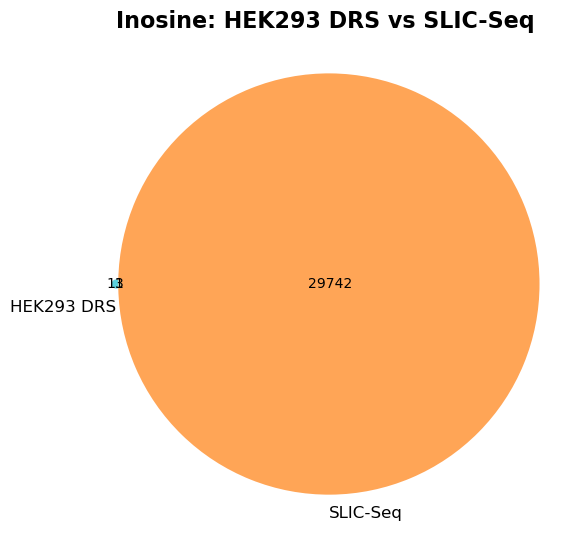

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

venn2([drs_sites, orth_sites],
      set_labels=['HEK293 DRS', 'SLIC-Seq'],
      set_colors=[INOSINE_COLORS['DRS_HEK293'], INOSINE_COLORS['Orthogonal']],
      alpha=ALPHA,
      ax=ax)

ax.set_title('Inosine: HEK293 DRS vs SLIC-Seq', 
             fontweight='bold', fontsize=16)

plt.tight_layout()
plt.show()